# CIFAR-10 Neural Network from Scratch

We will be building a machine learning model from scratch to train on the CIFAR-10 dataset using only NumPy, Pandas, and other basic libraries. The model will be a fully connected neural network that can classify images into 10 categories.

### Importing Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

### Load CIFAR-10 Dataset
The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

In [27]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Preprocessing
Normalize pixel values to the range [0, 1] and reshape

In [28]:
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

One-hot encode labels

In [29]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

c:\Users\sidha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Initialize Neural Network Parameters

In [30]:
input_size = 3072  
hidden_size = 256
output_size = 10
learning_rate = 0.01
epochs = 100
batch_size = 64
lambda_reg = 0.001
dropout_rate = 0.5

### Weight initialization using He Initialization

In [31]:
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
b2 = np.zeros((1, output_size))

### Activation Functions

In [32]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [33]:
def relu(z):
    return np.maximum(0, z)

In [34]:
def relu_derivative(z):
    return (z > 0).astype(float)

In [35]:
def compute_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

In [36]:
def batch_norm(Z):
    mean = np.mean(Z, axis=0, keepdims=True)
    variance = np.var(Z, axis=0, keepdims=True)
    Z_norm = (Z - mean) / np.sqrt(variance + 1e-8)
    return Z_norm

In [37]:
def dropout(A, rate):
    mask = (np.random.rand(*A.shape) > rate).astype(float) / (1.0 - rate)
    return A * mask, mask

In [38]:
def forward_propagation(X, W1, b1, W2, b2, dropout_rate):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(batch_norm(Z1))
    A1, mask = dropout(A1, dropout_rate)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2, mask

In [39]:
def backward_propagation(X, y_true, Z1, A1, A2, W1, W2, mask):
    m = X.shape[0]
    dZ2 = A2 - y_true
    dW2 = (1 / m) * np.dot(A1.T, dZ2) + lambda_reg * W2
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
    dZ1 *= mask
    dW1 = (1 / m) * np.dot(X.T, dZ1) + lambda_reg * W1
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2


### Training the Model

In [40]:
loss_history = []

In [41]:
for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        Z1, A1, Z2, A2, mask = forward_propagation(X_batch, W1, b1, W2, b2, dropout_rate)
        dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W1, W2, mask)
        
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
    
    loss = compute_loss(y_train, forward_propagation(X_train, W1, b1, W2, b2, dropout_rate)[-2])
    loss_history.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

Epoch 0: Loss = 2.0666
Epoch 10: Loss = 1.7253
Epoch 20: Loss = 1.6546
Epoch 30: Loss = 1.6134
Epoch 40: Loss = 1.5859
Epoch 50: Loss = 1.5667
Epoch 60: Loss = 1.5422
Epoch 70: Loss = 1.5237
Epoch 80: Loss = 1.5118
Epoch 90: Loss = 1.4994


### Plot Training Loss Curve

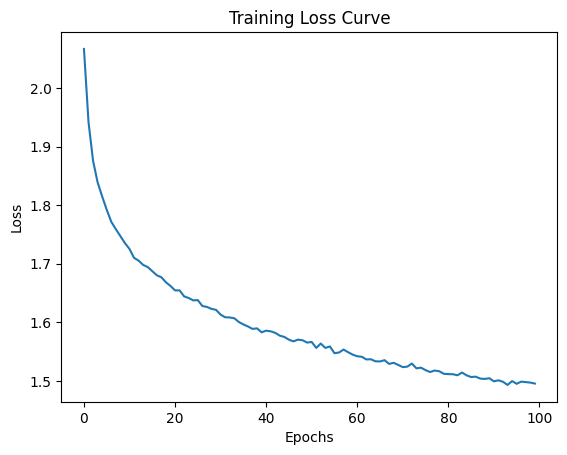

In [45]:
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

### Prediction Function

In [46]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2, _ = forward_propagation(X, W1, b1, W2, b2, 0)  # No dropout during inference
    return np.argmax(A2, axis=1)

### Evaluating the Model

In [47]:
y_pred = predict(X_test, W1, b1, W2, b2)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5113
